In [ ]:
import json
from graph import ScheduleGraph
import pandas as pd
import numpy as np
import time
import copy

## 1. Prepare planning data

In [ ]:
PLANING_PATH = 'data/planning.json'
f = open(PLANING_PATH, 'rb')
planning_data = json.load(f)

In [ ]:
schedule_graph = ScheduleGraph(planning_id = planning_data['planning_id'])

In [ ]:

schedule_data = planning_data['schedule']

In [ ]:
# Load data schedule to ScheduleGraph
schedule_graph.load_schedule(schedule_data)

In [ ]:
# set budget & duration

schedule_graph.set_budget_contraints(budget = 3000)
schedule_graph.set_planned_duration_constraint(duration = 20)

In [ ]:
# visualize task similality
schedule_graph.task_similarity_heatmap()

## 2. Load workforce

In [ ]:
WORKFORCE_DATA_PATH = '/Users/pvm/Desktop/Đồ Án/data/workforces.json'
f = open(WORKFORCE_DATA_PATH, 'rb')
workforce_data = json.load(f)
schedule_graph.load_workforce(workforce_data = workforce_data)

# 4. Load Contraints

## NSGA2 helper

### 1. Initial population

In [ ]:
def initial_popular(graph: ScheduleGraph, population_size: int) -> list:
    num_of_tasks = len(graph.task_list)
    population_list = np.empty((population_size, num_of_tasks), dtype=int)
    workforce_list = graph.workforce_list
    for i in range(population_size):
        for j in range(num_of_tasks):
            task = graph.task_list[j]
            available_workforce = graph.nodes[task]['available_workforce']
            available_workforce_indices = [index for index, value in enumerate(available_workforce.values()) if value]
            selected_index = np.random.choice(available_workforce_indices)
            selected_workforce = list(available_workforce.keys())[selected_index]
            population_list[i, j] = workforce_list.index(selected_workforce)

    return population_list

In [ ]:
def crossover(population_list, num_task: int, population_size: int):
    cosssover_offspring = [] # danh sách con cái được tạo ra từ crossover
    # Lấy ngẫu nhiên 2 parents
    random_parent_indices = list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
    for m in range(int(population_size/2)):
        parent_1= population_list[random_parent_indices[2*m]][:]

        parent_2= population_list[random_parent_indices[2*m+1]][:]
        child_1=parent_1[:]
        child_2=parent_2[:]
        
        # Lấy ngẫu nhiên 2 đoạn bất kỳ trong parent 1 chuyển cho parent 2
        cutpoint=list(np.random.choice(num_task, 2, replace=False))
        cutpoint.sort()
        child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
        child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
        
        cosssover_offspring.extend((child_1,child_2))
    return cosssover_offspring

In [ ]:
def mutation(offspring_list, num_task: int, muation_selection_rate: float, muation_rate: float):
    num_mutation_jobs = round(num_task*muation_selection_rate)
    # Thực hiện đảo ngược 1 gen
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if muation_rate <= mutation_prob:
            # chooses the position to mutation
            m_chg=list(np.random.choice(num_task, num_mutation_jobs, replace=False))
            # save the value which is on the first mutation position
            
            t_value_last=offspring_list[m][m_chg[0]] 
            
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last

    return offspring_list

In [ ]:
def non_dominated_sorting(population_size, chroms_obj_record):
    solution, non_dominate = {}, {}
    front, rank = {}, {}
    front[0] = []

    for p in range(population_size*2):
        solution[p] = []
        non_dominate[p] = 0
        for q in range(population_size * 2):
            is_dominated = False
            dominated_count = 0
            for obj in range(len(chroms_obj_record[p])):
               
                if chroms_obj_record[p][obj] > chroms_obj_record[q][obj]:
                    dominated_count += 1
                elif chroms_obj_record[p][obj] < chroms_obj_record[q][obj]:
                    is_dominated = True
                    break
               
            if is_dominated:
                if q not in solution[p]:
                    solution[p].append(q)

            elif not is_dominated and dominated_count == len(chroms_obj_record[p]):
                non_dominate[p] = non_dominate[p] + 1

    
        if non_dominate[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)
    
    
    i = 0
    while front[i] != []:
        Q = []
        for p in front[i]:
            for q in solution[p]:
                non_dominate[q] = non_dominate[q] - 1
                if non_dominate[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i = i + 1
        front[i] = Q

    del front[len(front) - 1]
    return front


def calculate_crowding_distance(front,chroms_obj_record):
    distance={m:0 for m in front}
    for o in range(len(chroms_obj_record[0])):
        obj={m:chroms_obj_record[m][o] for m in front}
        sorted_keys=sorted(obj, key=obj.get)
        distance[sorted_keys[0]]=distance[sorted_keys[len(front)-1]]=999999999999
        for i in range(1,len(front)-1):
            if len(set(obj.values()))==1:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]
            else:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]+(obj[sorted_keys[i+1]]-obj[sorted_keys[i-1]])/(obj[sorted_keys[len(front)-1]]-obj[sorted_keys[0]])
            
    return distance  

In [ ]:

def selection(front, population_size: int, chroms_obj_record: list, total_chromosome: list):   
    N=0
    new_pop=[]
    print("start selection.....")
    while N < population_size:
        for i in range(len(front)):
            
            if N > population_size:
                # Compare on each front after append solution with higher distance to new_pop
                distance=calculate_crowding_distance(front[i],chroms_obj_record)
                sorted_cdf=sorted(distance, key=distance.get)
                sorted_cdf.reverse()
                for j in sorted_cdf:
                    if len(new_pop)==population_size:
                        break   
                    if chroms_obj_record[j][1] > 0:
                        new_pop.append(j)       
                        N += 1       
                break
            else:
                for index in front[i]:
                    if chroms_obj_record[index][1] > 0: 
                        
                        new_pop.append(index)
                        N += 1
    
    print("Done selection.....")
    population_list=[]
    for n in new_pop:
        population_list.append(total_chromosome[n])
    
    print(f"population_list: {len(population_list)}")
    print(f"new_pop: {len(new_pop)}")
    return population_list, new_pop

In [ ]:
def compute_fitness(graph_copy: ScheduleGraph, total_chromosome: list, population_size: int):
    chroms_obj_record={} 
    for m in range(population_size*2):
        results = graph_copy.apply_assignment(assignment_list = total_chromosome[m])
        chroms_obj_record[m]=[1/results['actual_cost'], results['mapping_similarity'], results['assigned_similarity'], 1/results['actual_duration']]
    return chroms_obj_record

## NSGA2 Experiment

### Setup parammeters

In [ ]:
# Initial Resouces
POPULATION_SIZE = 200

# Initial NSGA2 params
NUMBER_ITERATION = 10
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.4
MUTATION_SELECTION_RATE = 0.4


### Initial population

In [ ]:
population_list = initial_popular(graph = schedule_graph, population_size=POPULATION_SIZE)

In [ ]:
population_list

### Running

In [ ]:
from tqdm import tqdm

best_list,best_obj=[],[]
for n in tqdm(range(NUMBER_ITERATION)):   
    schedule_graph_copy = copy.deepcopy(schedule_graph)

    parent_list=copy.deepcopy(population_list)
    offspring_list=[] # danh sách children
    
    # Crossover
    crossover_offspring = crossover(
        population_list = population_list,
        num_task = len(schedule_graph_copy.task_list),
        population_size = POPULATION_SIZE
    )
    offspring_list.extend(crossover_offspring)

    
    # Mutation
    offspring_list = mutation(
        offspring_list = offspring_list,
        num_task = len(schedule_graph_copy.task_list),
        muation_selection_rate = MUTATION_SELECTION_RATE,
        muation_rate = MUTATION_RATE
    )
    
   
    # Selection
    total_chromosome= copy.deepcopy(np.concatenate((parent_list, np.array(offspring_list))))
    chroms_obj_record = compute_fitness(
        total_chromosome = total_chromosome,
        graph_copy = schedule_graph_copy,
        population_size = POPULATION_SIZE
     )
   
    front=non_dominated_sorting(POPULATION_SIZE,chroms_obj_record)

    population_list,new_pop=selection(
        front = front,
        population_size = POPULATION_SIZE,
        chroms_obj_record = chroms_obj_record,
        total_chromosome = total_chromosome)
    
    new_pop_obj=[chroms_obj_record[k] for k in new_pop] 
   
    # Comparison
    if n==0:
        best_list=copy.deepcopy(population_list)
        best_obj=copy.deepcopy(new_pop_obj)
    
    else:            
        total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
        total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)
        start_time = time.time()
        
        now_best_front=non_dominated_sorting(
            population_size = POPULATION_SIZE,
            chroms_obj_record = total_obj)
        
        best_list,best_pop=selection(
            front = now_best_front,
            population_size = POPULATION_SIZE,
            chroms_obj_record = total_obj,
            total_chromosome = total_list)

        best_obj=[total_obj[k] for k in best_pop]

### Evaluate

In [ ]:
print('-----Results -----------------------------')
print("One chromosome(1x100)=",best_list[0])
print("best_obj=",best_obj[0])
print("------------------------------------------")
print('The elapsed time:%s'% (time.time() - start_time))

In [ ]:
import pandas as pd
df = pd.DataFrame(best_obj, columns = ['cost', 'assigned_level', 'quality', 'completed_time'])
df['solution'] = best_list

In [ ]:
df.describe()

In [ ]:
def estimate(graph: ScheduleGraph, assignment_list: list):
    return graph.apply_assignment(assignment_list=assignment_list)

In [ ]:
estimate(graph = schedule_graph, assignment_list = best_list[0])

### Visualize

In [ ]:
top = 2

output = schedule_graph.apply_assignment(assignment_list = best_list[top])
print(f"assigments: {best_list[top]}")
print(f"output: {output}")

schedule_graph.visualize()

In [ ]:
import random

num_tasks = 100

# Tạo ma trận TaskAdjacency với giá trị mặc định là 0 cho tất cả các cặp task
task_duration = [random.randint(1, 10) for _ in range(0, num_tasks) ]
task_duration[0] = 0
task_duration[num_tasks -1] = 0

print(task_duration)

In [1]:
import numpy as np
import random

def create_binary_adjacency_matrix(num_tasks):
    matrix = np.zeros((num_tasks, num_tasks), dtype=int)
    
    # Generate dependencies for each task
    for i in range(num_tasks):
        if i == 0:
            continue  # Skip the first task as it will be the start node
        num_dependencies = random.randint(1, min(3, i))  # Ensure at least one dependency
        dependencies = random.sample(range(i), num_dependencies)
        
        for dependency in dependencies:
            matrix[i, dependency] = 1
    
    # Connect start node (first task) to random tasks
    start_node_dependencies = random.sample(range(1, num_tasks), random.randint(0, min(3, num_tasks-1)))
    for dependency in start_node_dependencies:
        matrix[0, dependency] = 1
    
    # Connect random tasks to finish node (last task)
    finish_node_dependencies = random.sample(range(num_tasks-1), random.randint(0, min(3, num_tasks-1)))
    for dependency in finish_node_dependencies:
        matrix[dependency, num_tasks-1] = 1
    
    return matrix




In [2]:
import networkx as nx
import os
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np


def write_matrix(matrix, file_name):
    
    # Tạo đường dẫn đến tệp tin
    file_path = os.path.join(FOLDER_NAME, file_name)

    # Ghi ma trận vào tệp tin
    with open(file_path, 'w') as f:
        rows, cols = matrix.shape
        for i in range(rows):
            for j in range(cols):
                f.write(str(matrix[i, j]) + ' ')
            f.write('\n')

    return file_path


def save_pert_chart(TaskAdjacency):
    graph = nx.DiGraph()

    for i in range(len(TaskAdjacency)):
        graph.add_node(i)
        predencors = TaskAdjacency[i]
        for j in range(len(predencors)):
            if predencors[j] == 1:
                graph.add_edge(j, i)


    pos = graphviz_layout(graph, prog="dot")
    for k,v in pos.items():
        pos[k]=(-v[1],v[0])
    nx.draw_networkx_nodes(graph,pos = pos, node_shape = 's', node_size = 200, 
                        node_color = 'none', edgecolors='k')
    nx.draw_networkx_edges(graph,pos = pos, 
                        node_shape = 's', width = 1,  node_size = 200)
    nx.draw_networkx_labels(graph,pos = pos, font_size = 5)

    
    # Set up the figure size
    plt.figure(figsize=(10, 2))

    plt.savefig(f"{FOLDER_NAME}/pert.png")
    # Display the heatmap
    plt.show()


/var/folders/rn/hgwpqjn159ng5gy4gt_0wff40000gn/T/ipykernel_3040/3830429170.py:35: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


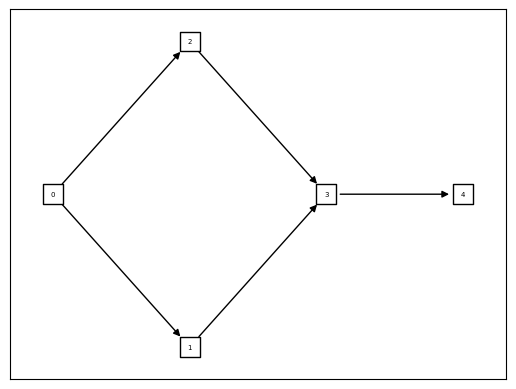

<Figure size 1000x200 with 0 Axes>

In [3]:
import numpy as np
import random
import time
import os




def generate_skill(num_skill, num_tasks):
    # Tạo ma trận TaskAdjacency với giá trị mặc định là 0 cho tất cả các cặp task
    task_skill = np.zeros((num_tasks, num_skill), dtype=int)

    # Đặt giá trị ngẫu nhiên (0 hoặc 1) cho các cặp task từ task 1 đến task 98
    for i in range(1, num_tasks - 1):
        task_skill[i] = np.random.randint(0, 6, size=num_skill)

    write_matrix(task_skill, file_name = "skill.txt")
    

def generate_duration(num_tasks):
    import random

    # Tạo ma trận TaskAdjacency với giá trị mặc định là 0 cho tất cả các cặp task
    task_duration = [random.randint(1, 10) for _ in range(0, num_tasks) ]
    task_duration[0] = 0
    task_duration[-1] = 0
    write_matrix(np.array([task_duration]), file_name = "duration.txt")

def generate_predence_matrix(num_tasks):
    # Tạo đồ thị DAG ngẫu nhiên
    graph = {}
    for i in range(1, num_tasks):
        dependencies = random.sample(range(i), random.randint(1, i))
        graph[i] = dependencies

    # Kiểm tra tính chu trình trong đồ thị
    stack = []
    visited = set()
    for node in range(num_tasks):
        if node not in visited:
            if has_cycle(graph, node, visited, stack):
                return None

    # Tạo ma trận predence task
    matrix = np.zeros((num_tasks, num_tasks), dtype=int)
    for task, dependencies in graph.items():
        for dependency in dependencies:
            matrix[task, dependency] = 1

    # Xóa cạnh trực tiếp từ node A đến node C nếu có cạnh từ node A đến node B và từ node B đến node C
    for i in range(num_tasks):
        for j in range(num_tasks):
            if matrix[i, j] == 1:
                for k in range(num_tasks):
                    if matrix[j, k] == 1:
                        matrix[i, k] = 0
    
    write_matrix(matrix, file_name = "task_matrix.txt")
    save_pert_chart(matrix)
    return matrix

def has_cycle(graph, node, visited, stack):
    visited.add(node)
    stack.append(node)

    for neighbor in graph.get(node, []):
        if neighbor not in visited:
            if has_cycle(graph, neighbor, visited, stack):
                return True
        elif neighbor in stack:
            return True

    stack.remove(node)
    return False


# Số lượng công việc
num_tasks =  100
num_skill = 10

# Tạo tên thư mục duy nhất dựa trên thời gian
FOLDER_NAME = str(int(time.time()))
os.makedirs(FOLDER_NAME, exist_ok=True)

generate_duration (num_tasks)
generate_skill(num_skill = num_skill, num_tasks = num_tasks)
matrix = generate_predence_matrix(num_tasks)